# Spaceship Titanic

Train dataframe description:
- **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
- **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- **Destination** - The planet the passenger will be debarking to.
- **Age** - The age of the passenger.
- **VIP** - Whether the passenger has paid for special VIP service during the voyage.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- **Name** - The first and last names of the passenger.
- **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [1]:
# Some modules that we are going to use.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, LearningCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

## Define Train and Test dataframe

In [2]:
# Define train and test dataframe.
train_df = pd.read_csv("../inputdata/train.csv", sep=",")
test_df = pd.read_csv("../inputdata/test.csv", sep=",")

print("Train_df shape:", train_df.shape)
print(train_df.describe())

print("\n\nFirst 10 samples:")
print(train_df.head(10))

Train_df shape: (8693, 14)
               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000  


First 10 samples:
  PassengerId HomePlanet CryoSleep  Cabin    Destina

## Explore the dataframes

### Missing values

In [3]:
print("Train missing values:")
print(train_df.isna().sum())

print("\n\nTest missing values:")
print(test_df.isna().sum())

Train missing values:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


Test missing values:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


### Print distributions

In [4]:
# Print distribution split by transported.
def distrib_split_by_transported(df, col_name):
    # Split into transported/not transported 
    not_tran= df[df["Transported"] == 0][col_name].dropna()
    tran = df[df["Transported"] == 1][col_name].dropna()
    
    # Create a stacked histogram
    plt.figure(figsize=(10, 6))
    plt.hist([not_tran, tran], bins=30, stacked=True, color=['blue', 'orange'], label=['Not transported', "Transported"], edgecolor='black')
    
    # Add labels and title
    plt.xlabel(col_name)
    plt.ylabel("Count")
    plt.title(f"{col_name} Distribution Split by Transported")
    plt.legend()
    plt.show()

['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported']


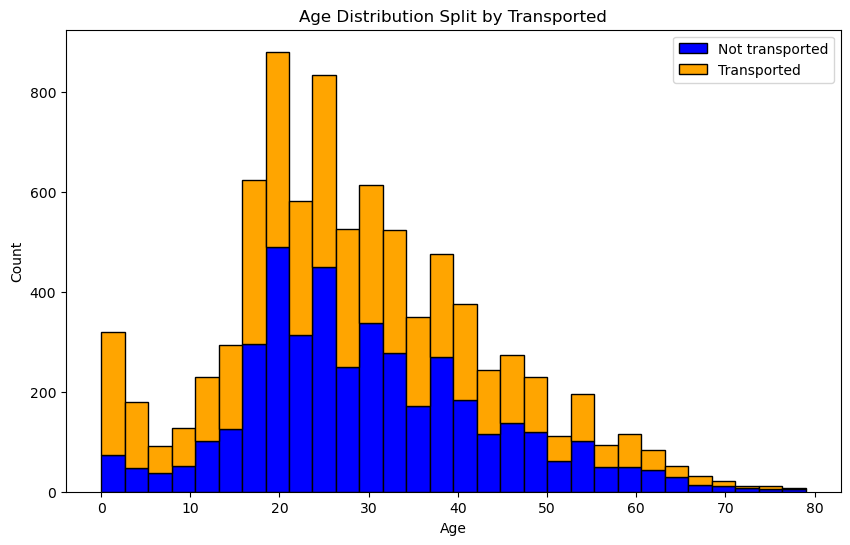

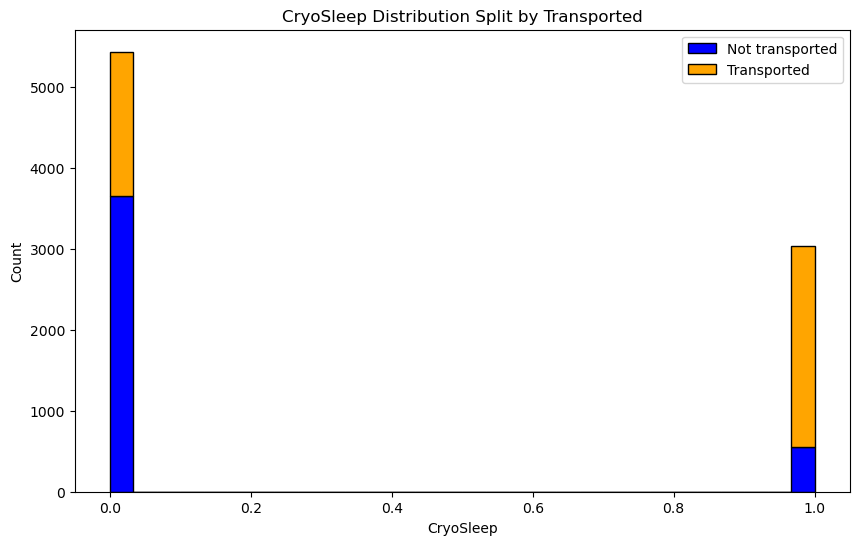

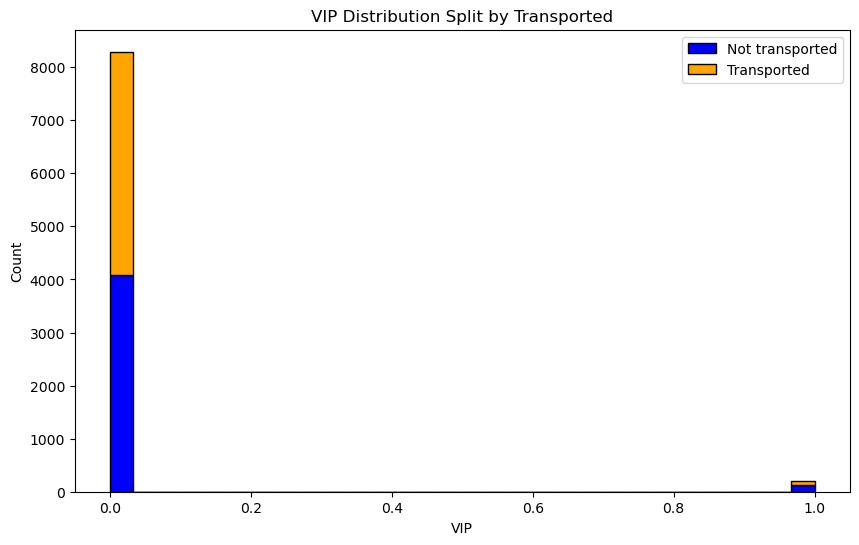

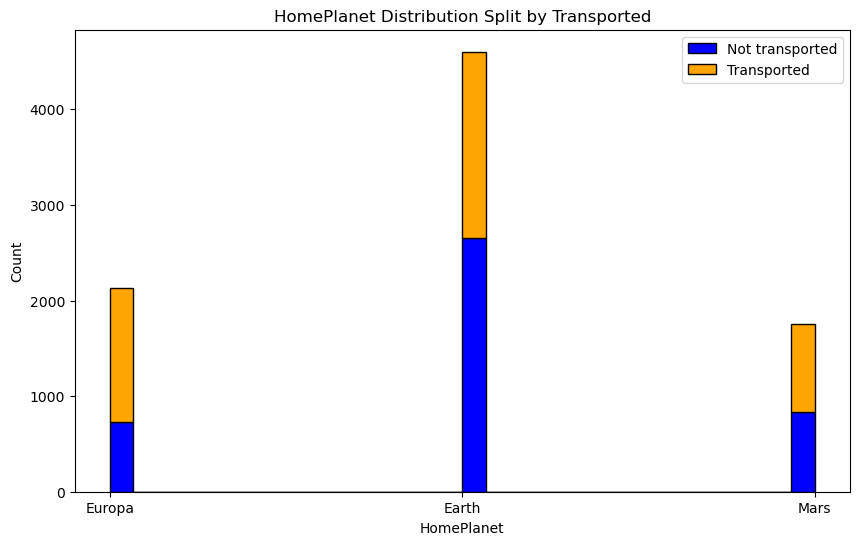

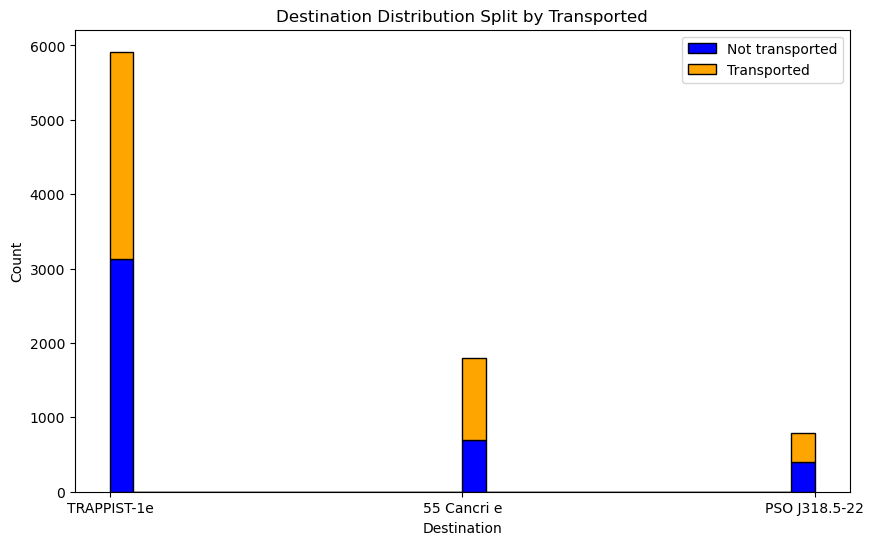

In [5]:
feature_names = list(train_df.columns)
print(feature_names)
for name in ["Age", "CryoSleep", "VIP", "HomePlanet", "Destination"]:
    distrib_split_by_transported(train_df, name)

### New feature: TotBill = RoomService + FoodCourt + ShoppingMall + Spa + VRDeck

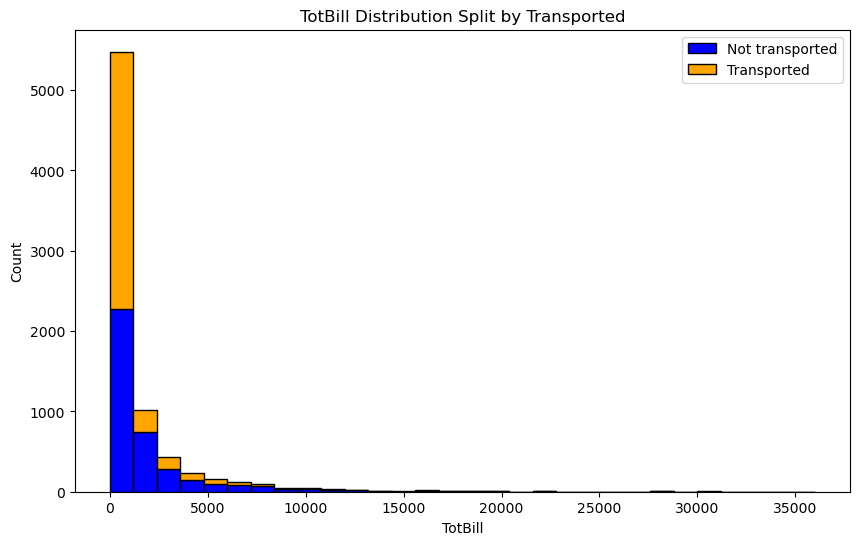

In [6]:
# Create a new column that contains the sum of the bills.
train_df["TotBill"] = train_df["RoomService"] + train_df["FoodCourt"] + train_df["ShoppingMall"] + train_df["Spa"] + train_df["VRDeck"]
distrib_split_by_transported(train_df, "TotBill")

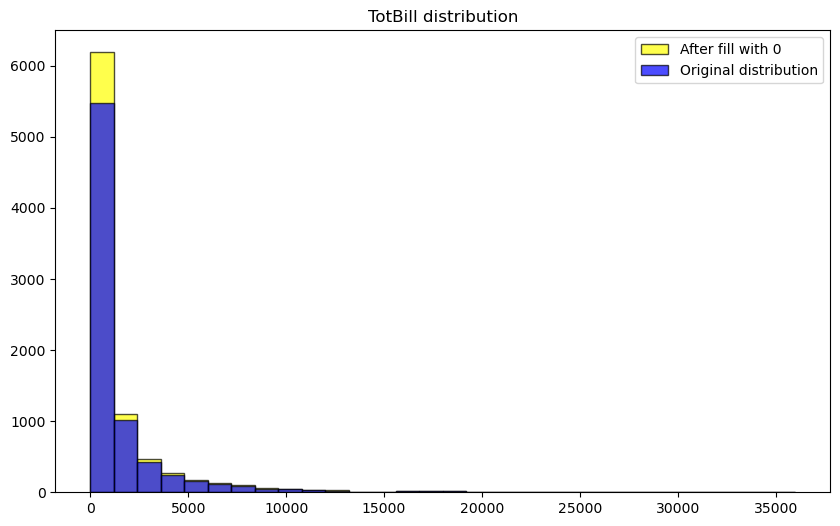

In [7]:
# Let's see how the distribution changes if we fill with 0's the missing data.
zero_fillna = (
    train_df["RoomService"].fillna(0) + 
    train_df["FoodCourt"].fillna(0) + 
    train_df["ShoppingMall"].fillna(0) + 
    train_df["Spa"].fillna(0) + 
    train_df["VRDeck"].fillna(0)
)

plt.figure(figsize=(10, 6))
plt.hist(zero_fillna.to_list(), bins=30, color='yellow', alpha=0.7, edgecolor='black', label="After fill with 0")
plt.hist(train_df["TotBill"].to_list(), bins=30, color='blue', alpha=0.7, edgecolor='black', label="Original distribution")
plt.title("TotBill distribution")
plt.legend()
plt.show()

In [8]:
# Let's replace the TotBill column with the zero_fillna.

# Train dataframe.
train_df["TotBill"] = zero_fillna

# Test dataframe.
test_df["TotBill"] = (
    test_df["RoomService"].fillna(0) + 
    test_df["FoodCourt"].fillna(0) + 
    test_df["ShoppingMall"].fillna(0) + 
    test_df["Spa"].fillna(0) + 
    test_df["VRDeck"].fillna(0)
)

# Drop the other columns.
train_df = train_df.drop(columns=["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"], axis=1)
test_df = test_df.drop(columns=["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"], axis=1)

### Categorize TotBill feature

TotBill
Low          3758
Mid          2819
High         1479
Very high     637
Name: count, dtype: int64


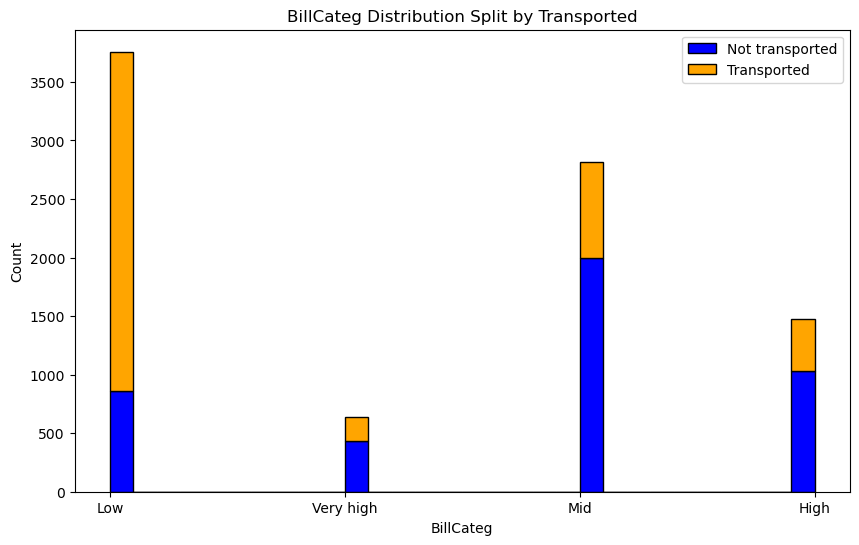

In [9]:
def categ_totbill(totbill):
    if totbill <= 500:
        return "Low"
    elif totbill <= 1500:
        return "Mid"
    elif totbill <= 5000:
        return "High"
    else:
        return "Very high"

# Train dataframe.
status_col = train_df["TotBill"].apply(categ_totbill)
print(status_col.value_counts())
train_df["BillCateg"] = status_col
distrib_split_by_transported(train_df, "BillCateg")

# Test dataframe.
test_df["BillCateg"] = test_df["TotBill"].apply(categ_totbill)

# Drop the TotBill column.
train_df = train_df.drop(columns="TotBill", axis=1)
test_df = test_df.drop(columns="TotBill", axis=1)

### New feature: Group

Extract the Group from the PassengerId column.

In [10]:
def get_group(Id):
    Id = Id.split("_")
    return Id[0]

# Train dataframe.
group_col = train_df["PassengerId"].apply(get_group)
print(group_col.value_counts())
train_df["Group"] = group_col
#distrib_split_by_transported(train_df, "Group")

# Train dataframe.
test_df["Group"] = test_df["PassengerId"].apply(get_group)

PassengerId
4256    8
5133    8
8956    8
8168    8
0984    8
       ..
3469    1
3468    1
3467    1
3465    1
3491    1
Name: count, Length: 6217, dtype: int64


### New feature: Deck

Cabin
F           2794
G           2559
E            876
B            779
C            747
D            478
A            256
FakeDeck     199
T              5
Name: count, dtype: int64


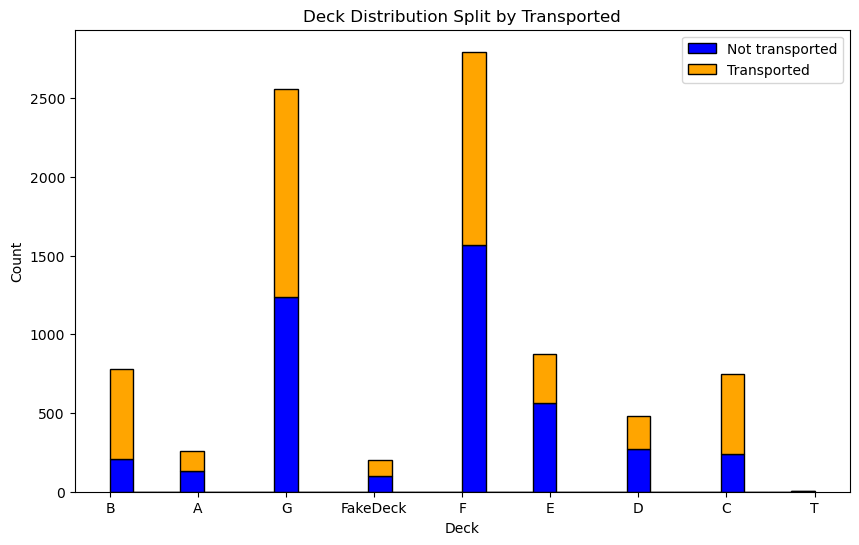

In [11]:
def get_deck(cabin):
    return cabin.split("/")[0]

# Train dataset.
deck_col = train_df["Cabin"].fillna("FakeDeck").apply(get_deck)
print(deck_col.value_counts())
train_df["Deck"] = deck_col
distrib_split_by_transported(train_df, "Deck")

# Test dataset.
test_df["Deck"] = test_df["Cabin"].fillna("FakeDeck").apply(get_deck)

### New feature: CabinNum

In [12]:
def get_cabinnum(cabin):
    if cabin == "FakeCabin":
        return -1
    return int(cabin.split("/")[1])

# Train dataframe.
cabinnum_col = train_df["Cabin"].fillna("FakeCabin").apply(get_cabinnum)
print(cabinnum_col.value_counts())
train_df["CabinNum"] = cabinnum_col

# Test dataframe.
test_df["CabinNum"] = test_df["Cabin"].fillna("FakeCabin").apply(get_cabinnum)

Cabin
-1       199
 82       28
 19       22
 86       22
 176      21
        ... 
 1863      1
 1864      1
 1865      1
 1761      1
 1866      1
Name: count, Length: 1818, dtype: int64


### New feature: CabinSide

Cabin
S           4288
P           4206
FakeSide     199
Name: count, dtype: int64


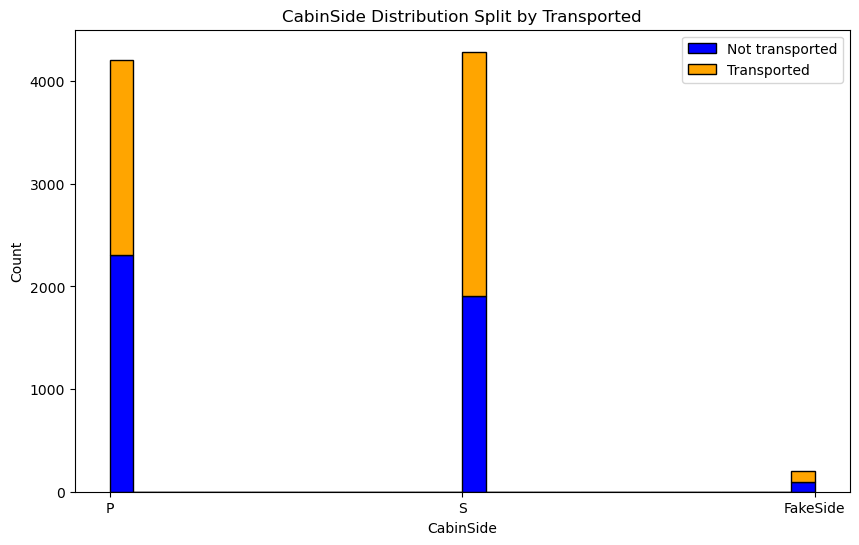

In [13]:
def get_cabinside(cabin):
    if cabin == "FakeCabin":
        return "FakeSide"
    return cabin.split("/")[2]

# Train dataframe.
cabinside_col = train_df["Cabin"].fillna("FakeCabin").apply(get_cabinside)
print(cabinside_col.value_counts())
train_df["CabinSide"] = cabinside_col
distrib_split_by_transported(train_df, "CabinSide")

# Test dataframe.
test_df["CabinSide"] = test_df["Cabin"].fillna("FakeCabin").apply(get_cabinside)

### HomePlanet, manage missing values

In [14]:
print("Tot passenger with nan HomePlanet that are part of a group of size > 1:", train_df.groupby(["Group"]).filter(lambda x: len(x) > 1)["HomePlanet"].isna().sum())
print("Tot passenger with nan HomePlanet that are lonely in the group:", train_df.groupby(["Group"]).filter(lambda x: len(x) == 1)["HomePlanet"].isna().sum())
print()
print("Tot passenger travelling in a group larger than 1", len(train_df.groupby(["Group"]).filter(lambda x: len(x) > 1).groupby("Group")))
print("Tot passenger travelling in a group larger that 1 that have same HomePlanet", len(train_df.groupby(["Group", "HomePlanet"]).filter(lambda x: len(x) > 1).groupby("Group").size()))

Tot passenger with nan HomePlanet that are part of a group of size > 1: 92
Tot passenger with nan HomePlanet that are lonely in the group: 109

Tot passenger travelling in a group larger than 1 1412
Tot passenger travelling in a group larger that 1 that have same HomePlanet 1370


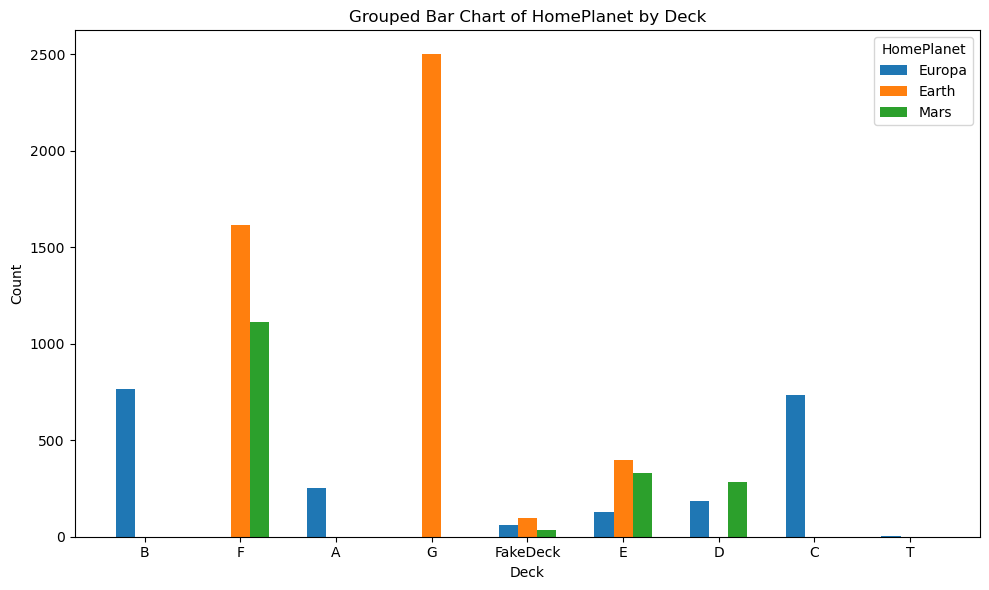

In [15]:
# Is there a relationship between Deck and HomePlanet?
deck_categ = train_df["Deck"].unique()
homep = train_df["HomePlanet"].dropna().unique()

counts = {deck: [len(train_df[(train_df["Deck"] == deck) & (train_df["HomePlanet"] == planet)]) for planet in homep] for deck in deck_categ}

bar_width = 0.2
x = np.arange(len(deck_categ))  # x positions for the groups.

# Plot bars for each class.
plt.figure(figsize=(10, 6))
for i, planet in enumerate(homep):
    plt.bar(x + i * bar_width, [counts[deck][i] for deck in deck_categ], width=bar_width, label=f"{planet}")

plt.xticks(x + bar_width, deck_categ)  # Center group labels.
plt.xlabel("Deck")
plt.ylabel("Count")
plt.title("Grouped Bar Chart of HomePlanet by Deck")
plt.legend(title="HomePlanet")

plt.tight_layout()
plt.show()

In [16]:
# We can try the following: consider the passenger that have a missing HomePlanet. If they are travelling in a group larger than one,
# then set missin HomePlanet to a value taken from one of the other member of the group.

group_sizes = train_df["Group"].map(train_df["Group"].value_counts())

def fill_home_planet(group):
    if group["HomePlanet"].isnull().any():
        non_null_planets = group["HomePlanet"].dropna()
        if not non_null_planets.empty:
            group["HomePlanet"] = group["HomePlanet"].fillna(non_null_planets.iloc[0])
    return group

# Train dataframe.
old_homeplanet_col = train_df["HomePlanet"].dropna()
train_df = train_df.groupby("Group", group_keys=False).apply(fill_home_planet)

# test dataframe.
test_df = test_df.groupby("Group", group_keys=False).apply(fill_home_planet)

/tmp/ipykernel_11171/7433388.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby("Group", group_keys=False).apply(fill_home_planet)
/tmp/ipykernel_11171/7433388.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df = test_df.groupby("Group", group_keys=False).apply(fill_home_planet)


In [17]:
# There are more missing values. Let's use the relation Deck-HomePlanet.

prob_F = np.array([
    len(train_df[(train_df["HomePlanet"] == "Earth") & (train_df["Deck"] == "F")]),
    len(train_df[(train_df["HomePlanet"] == "Mars") & (train_df["Deck"] == "F")])
])
prob_F = prob_F / sum(prob_F)

prob_D = np.array([
    len(train_df[(train_df["HomePlanet"] == "Europa") & (train_df["Deck"] == "D")]),
    len(train_df[(train_df["HomePlanet"] == "Mars") & (train_df["Deck"] == "D")])
])
prob_D = prob_D / sum(prob_D)

prob_E = np.array([
    len(train_df[(train_df["HomePlanet"] == "Europa") & (train_df["Deck"] == "E")]),
    len(train_df[(train_df["HomePlanet"] == "Mars") & (train_df["Deck"] == "E")]),
    len(train_df[(train_df["HomePlanet"] == "Earth") & (train_df["Deck"] == "E")]),
])
prob_E = prob_E / sum(prob_E)

prob_FakeDeck = np.array([
    len(train_df[(train_df["HomePlanet"] == "Europa") & (train_df["Deck"] == "FakeDeck")]),
    len(train_df[(train_df["HomePlanet"] == "Mars") & (train_df["Deck"] == "FakeDeck")]),
    len(train_df[(train_df["HomePlanet"] == "Earth") & (train_df["Deck"] == "FakeDeck")]),
])
prob_FakeDeck = prob_FakeDeck / sum(prob_FakeDeck)

print(prob_F, prob_D, prob_E, prob_FakeDeck)

def fill_home_planet_2(row):
    if row["HomePlanet"] is not np.nan:
        return row
    elif row["Deck"] in ["A", "B", "C"]:
        row["HomePlanet"] = "Europa"
        return row
    elif row["Deck"] == "G":
        row["HomePlanet"] = "Earth"
        return row
    elif row["Deck"] == "F":
        row["HomePlanet"] = np.random.choice(["Earth", "Mars"], p=prob_F)
        return row
    elif row["Deck"] == "D":
        row["HomePlanet"] = np.random.choice(["Europa", "Mars"], p=prob_D)
        return row
    elif row["Deck"] == "E":
        row["HomePlanet"] = np.random.choice(["Europa", "Mars", "Earth"], p=prob_E)
        return row
    elif row["Deck"] == "FakeDeck":
        row["HomePlanet"] = np.random.choice(["Europa", "Mars", "Earth"], p=prob_FakeDeck)
        return row
    else:
        row["HomePlanet"] = "Earth"
        return row

# Train dataframe.
train_df = train_df.apply(fill_home_planet_2, axis=1)

# Test dataframe (use the same probability used before)
test_df = test_df.apply(fill_home_planet_2, axis=1)

[0.58909091 0.41090909] [0.39873418 0.60126582] [0.15028902 0.38728324 0.46242775] [0.31794872 0.18974359 0.49230769]


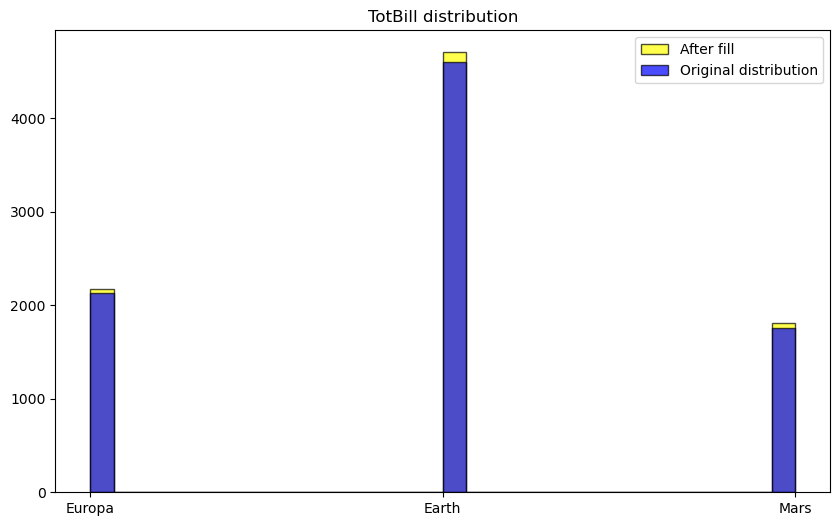

In [18]:
plt.figure(figsize=(10, 6))
plt.hist(train_df["HomePlanet"].to_list(), bins=30, color='yellow', alpha=0.7, edgecolor='black', label="After fill")
plt.hist(old_homeplanet_col.to_list(),bins=30, color='blue', alpha=0.7, edgecolor='black', label="Original distribution")
plt.title("TotBill distribution")
plt.legend()
plt.show()

### Drop some features

In [19]:
train_df = train_df.drop(columns=["PassengerId", "Cabin", "Name", "Group"], axis=1)
print(train_df.isna().sum())
print("\n\n")
test_df = test_df.drop(columns=["Cabin", "Name", "Group"], axis=1)
print(test_df.isna().sum())

HomePlanet       0
CryoSleep      217
Destination    182
Age            179
VIP            203
Transported      0
BillCateg        0
Deck             0
CabinNum         0
CabinSide        0
dtype: int64



PassengerId     0
HomePlanet      0
CryoSleep      93
Destination    92
Age            91
VIP            93
BillCateg       0
Deck            0
CabinNum        0
CabinSide       0
dtype: int64


## Encode categorical features

In [20]:
X_train = train_df.dropna().drop(columns="Transported")
X_test = test_df.dropna()
Y_train = train_df.dropna()["Transported"]

print("Tot number of samples in train set:", X_train.shape[0])
features_names = list(X_train.columns)
print("Features names:", features_names)

X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values

Tot number of samples in train set: 7937
Features names: ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'BillCateg', 'Deck', 'CabinNum', 'CabinSide']


In [21]:
# Print the data type of each column.
for index_col, name_col in zip(range(X_train.shape[1]), features_names):
    print(f"Column {name_col} (index: {index_col}) -- data type: {type(X_train[0, index_col])}")

Column HomePlanet (index: 0) -- data type: <class 'str'>
Column CryoSleep (index: 1) -- data type: <class 'bool'>
Column Destination (index: 2) -- data type: <class 'str'>
Column Age (index: 3) -- data type: <class 'float'>
Column VIP (index: 4) -- data type: <class 'bool'>
Column BillCateg (index: 5) -- data type: <class 'str'>
Column Deck (index: 6) -- data type: <class 'str'>
Column CabinNum (index: 7) -- data type: <class 'int'>
Column CabinSide (index: 8) -- data type: <class 'str'>


In [22]:
# Encode the categorical variables.
to_encode = np.array([0, 1, 2, 4, 5, 6, 8])

enc = OrdinalEncoder()

enc.fit(X_train[:, to_encode])
X_train[:, to_encode] = enc.transform(X_train[:, to_encode])
X_test[:, to_encode+1] = enc.transform(X_test[:, to_encode+1])

# Print the data type of each column.
for index_col, name_col in zip(range(X_train.shape[1]), features_names):
    print(f"Column {name_col} (index: {index_col}) -- data type: {type(X_train[0, index_col])}")

Column HomePlanet (index: 0) -- data type: <class 'float'>
Column CryoSleep (index: 1) -- data type: <class 'float'>
Column Destination (index: 2) -- data type: <class 'float'>
Column Age (index: 3) -- data type: <class 'float'>
Column VIP (index: 4) -- data type: <class 'float'>
Column BillCateg (index: 5) -- data type: <class 'float'>
Column Deck (index: 6) -- data type: <class 'float'>
Column CabinNum (index: 7) -- data type: <class 'int'>
Column CabinSide (index: 8) -- data type: <class 'float'>


## Split in Train validation set

In [23]:
m = X_train.shape[0]
m_train = int(4./5. * m)
m_val = m - m_train

print("Amount of data for training set:", m_train)
print("Amount of data for validation set", m_val)

# Split into train and validation.
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=m_val/m, random_state=12)

# Check size of sets.
print("Training size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])

Amount of data for training set: 6349
Amount of data for validation set 1588
Training size: 6349
Validation size: 1588


## Standardize data

In [24]:
# Standardize age and fare columns.
to_scale = np.array([3, 7])

# Create a copy for each set.
X_train_scaled = np.copy(X_train)
X_val_scaled = np.copy(X_val)
X_test_scaled = np.copy(X_test)

# Scale data.
scaler = StandardScaler().fit(X_train[:, to_scale])
X_train_scaled[:, to_scale] = scaler.transform(X_train[:, to_scale])
X_val_scaled[:, to_scale] = scaler.transform(X_val[:, to_scale])
X_test_scaled[:, to_scale+1] = scaler.transform(X_test[:, to_scale+1])

## Random Forest

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Optimal param: {'max_depth': 10, 'random_state': 12}


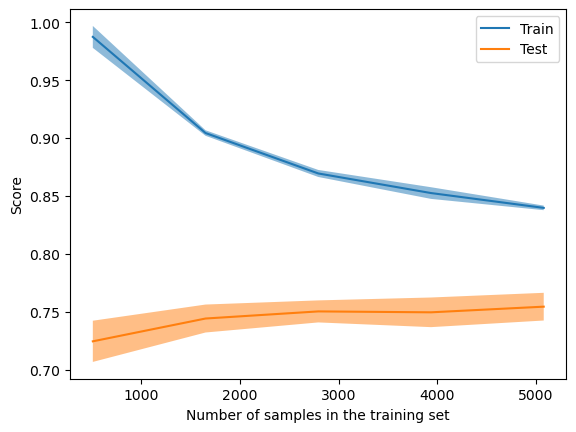

In [25]:
param_grid = {
    "max_depth": [None, 5, 7, 10, 12], 
    "random_state": [12]
}

rf_gs = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, verbose=1)
rf_gs.fit(X_train_scaled, Y_train)
print("Optimal param:", rf_gs.best_params_)
LearningCurveDisplay.from_estimator(rf_gs.best_estimator_, X_train_scaled, Y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Optimal param: {'max_depth': 7, 'random_state': 12}


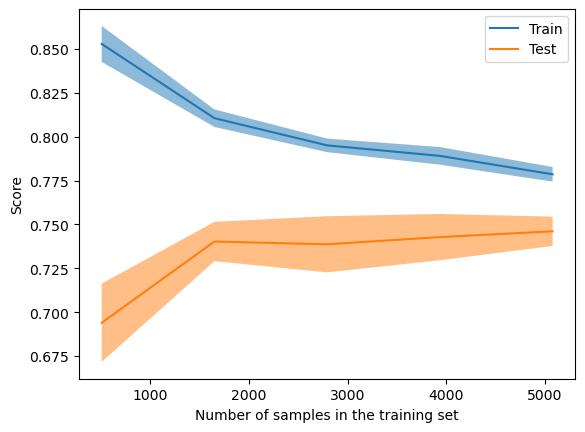

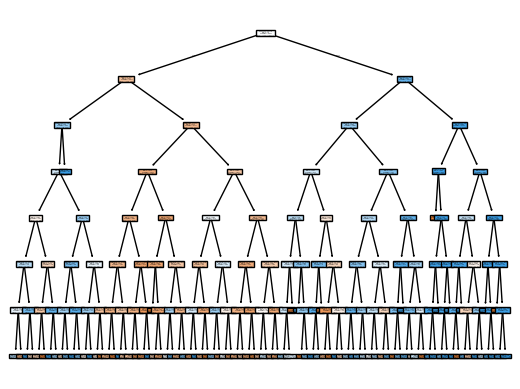

['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'BillCateg', 'Deck', 'CabinNum', 'CabinSide']
[0.09667283 0.5696145  0.00752053 0.09167162 0.         0.00477155
 0.05616691 0.14185555 0.03172651]


In [26]:
param_grid = {
    "max_depth": [None, 5, 7, 10, 12], 
    "random_state": [12]
}

dt_gs = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=10, verbose=1)
dt_gs.fit(X_train_scaled, Y_train)
print("Optimal param:", dt_gs.best_params_)
LearningCurveDisplay.from_estimator(dt_gs.best_estimator_, X_train_scaled, Y_train)

# Plot the tree of the final model.
from sklearn import tree

plt.figure()
tree.plot_tree(decision_tree=dt_gs.best_estimator_,
               feature_names=features_names, 
               filled=True)
plt.savefig("tree.pdf")
plt.show()

print(features_names)
print(dt_gs.best_estimator_.feature_importances_)

In [27]:
print(rf_gs.best_estimator_.score(X_val_scaled, Y_val))
print(dt_gs.best_estimator_.score(X_val_scaled, Y_val))

0.7468513853904282
0.7449622166246851


## Create submission

In [28]:
# Compute predictions.
predictions = rf_gs.best_estimator_.predict(X_test[:, 1:])

# Save predictions.
output = pd.DataFrame({'PassengerId': test_df["PassengerId"], 'Transported': predictions}) 
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

ValueError: array length 3926 does not match index length 4277